# General Imports

In [ ]:
import numpy as np
import numpy.typing as npt
import os
import pandas as pd
import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import matplotlib.cm as cm
import seaborn as sns

from functools import singledispatch
import warnings
import logging

# dataset
from sklearn.datasets import fetch_kddcup99
from sklearn.preprocessing import StandardScaler

# pyspark module
from pyspark.rdd import RDD

# src module
from src.utils import *
from src.kmeans.base import *
from src.kmeans.initialization import *
from src.kmeans.update import *

# Acess Spark Application

In [ ]:
# Setup the spark warnings
warnings.filterwarnings("ignore") 
logging.getLogger('py4j').setLevel(logging.ERROR) 
logging.getLogger('pyspark').setLevel(logging.ERROR) 
log4j_conf_path = "./Settings//log4j.properties"

In [ ]:
### DOCKER VERSION
from pyspark.sql import SparkSession

spark = (SparkSession.builder 
        .appName("kMeans") 
        .master("spark://spark-master:7077") 
        .config("spark.driver.memory", "4g") 
        .config("spark.executor.memory", "4g") 
        .config("spark.executor.cores", "2") 
        .config("spark.cores.max", "8") 
        .config("spark.network.timeout", "600s")   
        .config("spark.executor.heartbeatInterval", "60s") 
        .getOrCreate()
        )
sc = spark.sparkContext
sc.setLogLevel("ERROR")

sc.addPyFile("src.zip")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/13 10:44:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load and Test datasets

## Gaussian Mixture

The first dataset we would consider to test the performance of the k-means++ initialization algorithm is a synthetic GaussMixture. To generate it, we sampled $k$ centers from a 15-dimensional spherical Gaussian distribution with mean at the origin and variance $R\in \{1,10,100\}$. We then added points from Gaussian distributions of unit variance around each center. Given the $k$ centers, this is a mixture of $k$ spherical Gaussians with equal weights. The value of the optimal k-clustering
can be well approximated using the centers of these Gaussians.

We will perform some preliminary analysis that can be efficiently conducted on this dataset.

In [ ]:
def gauss_mixture(
    n: int=50,  
    k: int=10,
    dim: int=15,                  
    R: int=10
) -> RDD:
    seed = 42
    np.random.seed(seed)
    # Centers generation N(0, R*I)
    centers = np.random.normal(loc=0, scale=np.sqrt(R), size=(k, dim))
    # Point generation N(center, I) for each cluster
    return np.concatenate(
        [center + np.random.randn(n, dim) for center in centers],
        axis=0
    ), centers

# kMeans|| Init Tests

## Time / Cost tables

The first thing we want to assess with this dataset is the performance in terms of time and cost using different initialization algorithms. In particular, we chose to initialize our k-means algorithm with four different methods:

- **random**;
- **k-means++**;
- **k-means||** with $l\cdot k = 0.5$;
- **k-means||** with $l\cdot k = 2$.

Each initialization method is followed by Lloyd's iterations.

This setup allows us to investigate whether the parallelization introduced by the k-means|| initialization leads to improved clustering performance, using random and k-means++ initializations as baselines.

In [ ]:
def compute_time_cost(gm_narray, data_rdd, gm_true_cost, k, R, iterations, lk=1, r=5, init_algo="random"):

    # Initialization
    start = time.time()
    
    if init_algo == "random": 
        centroidsRandom = kMeansRandom_init(data_rdd, k)
    elif init_algo == "kmeans++": 
        centroidsRandom = kMeansPlusPlus_init(gm_narray, k)
    elif init_algo == "kmeans||": 
        centroidsRandom = kMeansParallel_init(data_rdd, k, int(lk*k), r)
    else: 
        raise ValueError(f"Wrong initialization algorithm selected: '{init_algo}'")
         
    init_time = time.time() - start
    seed_cost = compute_cost(data_rdd, centroidsRandom)

    # Algo
    start = time.time()
    final_centroids = lloydKMeans(data_rdd, centroidsRandom, iterations)
    final_time = time.time() - start
    final_cost = compute_cost(data_rdd, final_centroids)

    # Store the results in a dictionary
    results = []
    results.append({
        "R": R,
        "init_algo": init_algo,
        "init_time (s)": init_time,
        "up_time (s)": final_time,
        "seed": seed_cost,
        "final": final_cost,
        "true": gm_true_cost
    })
    
    results = pd.DataFrame(results)
    
    return results

In [ ]:
def exp10_cost(cost, frac_digits=2):
    """Return exponent 'a' s.t. cost ~10^a, rounded to 'frac_digits' decimals."""
    return float(np.round(np.log10(float(cost)), frac_digits))

### GM dataset creation

We need to create three different dataset for each value of $R \in \{1, 10, 100\}$.

In [ ]:
# --- control parameters ---
k = 50
n = 10_000
dim = 15
R = [1, 10, 100]
r = 5
iterations = 1000

# toy parameters for testing
"""k = 5
n = 100
dim = 15
R = [1, 10, 100]
r = 5
iterations = 10"""

In [ ]:
def create_gm_data(n, k, dim, R, sc):
    """
    Create dataset for different values of R
    """
    gm_narray, true_centroids = gauss_mixture(n, k, dim, R)
    gm_df = pd.DataFrame(gm_narray)
    gm_rdd = sc.parallelize([row for row in gm_narray])
    gm_rdd.count() 
    gm_true_cost = compute_cost(gm_rdd, true_centroids)

    return {
        "narray": gm_narray,
        "df": gm_df,
        "rdd": gm_rdd,
        "true_centroids": true_centroids,
        "true_cost": gm_true_cost,
    }

In [ ]:
datasets = {RR: create_gm_data(n, k, dim, RR, sc) for RR in R}

In [ ]:
datasets[1]["true_cost"]

15.12295504863026

In [ ]:
datasets[10]["true_cost"]

15.197356017266493

In [ ]:
datasets[100]["true_cost"]

15.197356017266493

### Random initialization + Lloyd algorithm

In [ ]:
results_rand_list = []
for RR in R:
    res = compute_time_cost(
        gm_narray=datasets[RR]["narray"],
        data_rdd=datasets[RR]["rdd"],
        gm_true_cost=datasets[RR]["true_cost"],
        k=k,
        R=RR,
        iterations=iterations,
        lk=1,
        r=r,
        init_algo="random",
    )
    results_rand_list.append(res)

results_rand = pd.concat(results_rand_list, ignore_index=True)

   R init_algo  init_time (s)  up_time (s)      seed      final       true
0  1    random        2.85204    28.324692  33.91794  14.947091  15.122955


    R init_algo  init_time (s)  up_time (s)        seed      final       true
0  10    random       3.560877    32.916883  112.610351  29.608966  15.197356


     R init_algo  init_time (s)  up_time (s)         seed       final  \
0  100    random       2.635231    35.299526  1693.121882  601.246278   

        true  
0  15.197356  


### kmeans++ initialization + LLoyd algorithm

In [ ]:
results_plus_list = []
for RR in R:
    res = compute_time_cost(
        gm_narray=datasets[RR]["narray"],
        data_rdd=datasets[RR]["rdd"],
        gm_true_cost=datasets[RR]["true_cost"],
        k=k,
        R=RR,
        iterations=iterations,
        lk=1,
        r=r,
        init_algo="kmeans++",
    )
    results_plus_list.append(res)

results_plus = pd.concat(results_plus_list, ignore_index=True)

   R init_algo  init_time (s)  up_time (s)       seed      final       true
0  1  kmeans++       0.053623    12.997394  32.042689  14.947757  15.122955


    R init_algo  init_time (s)  up_time (s)       seed      final       true
0  10  kmeans++       0.006725    11.726718  32.012204  15.050722  15.197356


     R init_algo  init_time (s)  up_time (s)       seed      final       true
0  100  kmeans++       0.004874    21.475211  26.993266  15.050722  15.197356


### kmeans|| init + Lloyd algorithm

In [ ]:
results_par1_list = []
for RR in R:
    res = compute_time_cost(
        gm_narray=datasets[RR]["narray"],
        data_rdd=datasets[RR]["rdd"],
        gm_true_cost=datasets[RR]["true_cost"],
        k=k,
        R=RR,
        iterations=iterations,
        lk=0.5,
        r=r,
        init_algo="kmeans||",
    )
    results_par1_list.append(res)

results_par1 = pd.concat(results_par1_list, ignore_index=True)

   R init_algo  init_time (s)  up_time (s)       seed      final       true
0  1  kmeans||       8.598313    22.956578  22.371284  16.277404  15.122955


    R init_algo  init_time (s)  up_time (s)      seed      final       true
0  10  kmeans||      24.753145    14.204458  24.76281  15.050722  15.197356


     R init_algo  init_time (s)  up_time (s)       seed      final       true
0  100  kmeans||      23.681348    15.634862  18.496032  15.050722  15.197356


In [ ]:
results_par2_list = []
for RR in R:
    res = compute_time_cost(
        gm_narray=datasets[RR]["narray"],
        data_rdd=datasets[RR]["rdd"],
        gm_true_cost=datasets[RR]["true_cost"],
        k=k,
        R=RR,
        iterations=iterations,
        lk=2,
        r=r,
        init_algo="kmeans||",
    )
    results_par2_list.append(res)

results_par2 = pd.concat(results_par2_list, ignore_index=True)

   R init_algo  init_time (s)  up_time (s)       seed      final       true
0  1  kmeans||       7.689777     8.195151  16.454436  14.947867  15.122955


    R init_algo  init_time (s)  up_time (s)       seed      final       true
0  10  kmeans||      16.343254    10.051638  16.888192  15.050722  15.197356


     R init_algo  init_time (s)  up_time (s)       seed      final       true
0  100  kmeans||      14.211719     9.990407  15.796554  15.050722  15.197356


In [ ]:
# Rename kmeans|| columns 
results_par1["init_algo"] = "kmeans|| (l*k=0.5)" 
results_par2["init_algo"] = "kmeans|| (l*k=2)" 

# Concatenate all the dataframes 
df_all = pd.concat([results_rand, results_plus, results_par1, results_par2], ignore_index=True) 

In [ ]:
results_rand

In [ ]:
results_plus

In [ ]:
results_par1

In [ ]:
results_par2

## Tables results visualization

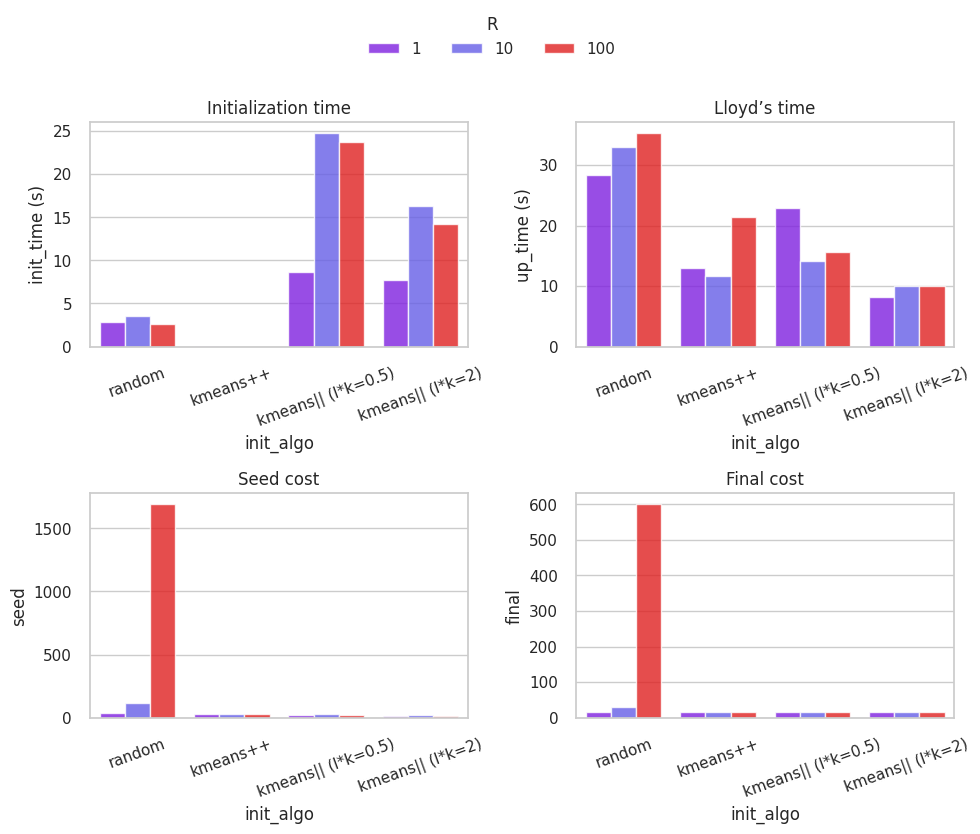

In [ ]:
sns.set(style="whitegrid")
matplotlib.rcParams.update({'font.size': 12})

# Define metrics and titles
metrics = ["init_time (s)", "up_time (s)", "seed", "final"]
titles = ["Initialization time", "Lloyd’s time", "Seed cost", "Final cost"]

# Plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for ax, metric, title in zip(axs.flat, metrics, titles):
    sns.barplot(
        data=df_all,
        x="init_algo",
        y=metric,
        hue="R",
        palette="rainbow",
        alpha=0.8,
        ax=ax
    )
    ax.set_title(title)
    ax.set_ylabel(metric)
    ax.tick_params(axis="x", rotation=20)
    ax.get_legend().remove() 

# Legend comune in alto
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper center",
    ncol=len(labels),
    title="R",
    bbox_to_anchor=(0.5, 1.05)  
)

plt.savefig("time_cost_comparison.pdf")
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

## Cost vs. r plots

In [ ]:
def run_curves(data_rdd, k, rounds, lk_ratio, iterations):
    curves = {lk: [] for lk in lk_ratio}
    
    for lk in lk_ratio:
        for r in rounds:
            if r==0:         
                C_psi = kMeansRandom_init(data_rdd, 1)
                psi = compute_cost(data_rdd, C_psi)
                curves[lk].append(exp10_cost(psi, 2))
            else:
                C0   = kMeansParallel_init(data_rdd, k=k, l=int(lk*k), r=int(r))
                Cfin = lloydKMeans(data_rdd, C0, iterations)
                phi  = compute_cost(data_rdd, Cfin)          
                curves[lk].append(exp10_cost(phi, 2))
                
            print(f"COMPLETED: \n##########|\tl/k = {lk}  |  r = {r}\t|##########")
        print("DONE!")
        
    return curves

### Plot

In [ ]:
# --- control parameters --- 

# Actual parameters
lk_ratio = [1, 2, 5, 10]
rounds = list(range(16))

# Toy parameters
#rounds = list(range(0, 5, 2))
#lk_ratio = [1, 2]

### kmeans|| init + Lloyd algorithm

In [ ]:
results = {}

for RR in R:
    data_rdd = datasets[RR]["rdd"]
    data_narray = datasets[RR]["narray"]

    # compute curves (KM|| seeds + Lloyd)
    print(f"Running for R={RR}")
    curves = run_curves(data_rdd, k, rounds, lk_ratio, iterations)

    # baseline (KM++ seeds + Lloyd)
    Cpp    = kMeansPlusPlus_init(data_narray, k)
    CppFin = lloydKMeans(data_rdd, Cpp, epochs=iterations)
    base   = exp10_cost(compute_cost(data_rdd, CppFin), 2)

    results[RR] = {
        "curves": curves,
        "base": base,
        "rounds": rounds,
        "lk_ratio": lk_ratio
    }

Running for R=1


COMPLETED: 
##########|	l/k = 1  |  r = 0	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 1	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 2	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 3	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 4	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 5	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 6	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 7	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 8	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 9	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 10	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 11	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 12	|##########


In [ ]:
def plot_results(results_dict):
    matplotlib.rcParams.update({'font.size': 16})
    
    fig, axes = plt.subplots(1, len(results_dict), figsize=(18, 6), sharey=True)

    for idx, (RR, res) in enumerate(results_dict.items()):
        ax = axes[idx]

        curves = res["curves"]
        base = res["base"]
        rounds = res["rounds"]

        # colormap
        lk_values = sorted(curves.keys())
        colors = cm.rainbow(np.linspace(0, 1, len(lk_values)))

        # markers and lines styles
        markers = ["s", "o", "X", "^"]
        lines = ["solid", "dotted", "dashed", "dashdot"]

        for lk, color, marker, line in zip(lk_values, colors, markers, lines):
            phis = curves[lk]
            ax.plot(rounds, phis, marker=marker, markersize=8, markerfacecolor="none", color=color, 
                    linewidth=1.5, linestyle=line, alpha=0.8, label=f"l/k={lk}")

        ax.axhline(base, color="k", lw=1, linestyle="solid", label="KM++ & Lloyd baseline")

        ax.set_title(f"R = {RR}", fontsize=16)
        ax.set_xlabel("# Initialization Rounds")
        if idx == 0:
            ax.set_ylabel("Cost (~$10^{\\alpha}$)")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: rf"$10^{{{y:.2f}}}$"))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend(frameon=False)

    plt.savefig("lk_plot.pdf")
    plt.tight_layout()
    plt.show()

In [ ]:
plot_results(results)

# Lloyd Parallel vs. nPartitions

# Lloyd vs. Mini-Batch

### Bibliography
[1.1] Bahmani, Bahman, et al. "Scalable k-means++." arXiv preprint arXiv:1203.6402 (2012).